Configurando a Visualização

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de visualização
sns.set_style('whitegrid')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Carregando os Dados

In [10]:
try:
    df_players = pd.read_csv('/content/sample_data/PicMoney-Base_Cadastral_de_Players-10_000 linhas (1).csv', delimiter=';')
    df_transacoes = pd.read_csv('/content/sample_data/PicMoney-Base_de_Transa__es_-_Cupons_Capturados-100000 linhas (1).csv')
    df_pedestres = pd.read_csv('/content/sample_data/PicMoney-Base_Simulada_-_Pedestres_Av__Paulista-100000 linhas (1).csv')
    df_lojas = pd.read_csv('/content/sample_data/PicMoney-Massa_de_Teste_com_Lojas_e_Valores-10000 linhas (1).csv')

    print("Todos os arquivos foram carregados com sucesso!")
except FileNotFoundError as e:
    print(f"Erro: Arquivo não encontrado. Verifique o nome e o caminho do arquivo: {e}")
except Exception as e:
    print(f"Ocorreu um erro ao carregar os arquivos: {e}")

Carregando os Dados...
Arquivo df_players carregado com sucesso!
Arquivo df_transacoes carregado com sucesso!
Arquivo df_pedestres carregado com sucesso!
Arquivo df_lojas carregado com sucesso!

Tentativa de carregamento de todos os arquivos concluída.


Mostra uma amostragem dos dados brutos

In [11]:
print("--- 1. Base Cadastral de Players ---")
print("Info:")
df_players.info()
print("\nValores Nulos:")
print(df_players.isnull().sum())
print("\nAmostra dos Dados:")
print(df_players.head())
print("\n" + "="*50 + "\n")


print("--- 2. Base de Transações ---")
print("Info:")
df_transacoes.info()
print("\nValores Nulos:")
print(df_transacoes.isnull().sum())
print("\nAmostra dos Dados:")
print(df_transacoes.head())
print("\n" + "="*50 + "\n")


print("--- 3. Base de Pedestres (Av. Paulista) ---")
print("Info:")
df_pedestres.info()
print("\nValores Nulos:")
print(df_pedestres.isnull().sum())
print("\nAmostra dos Dados (com problema de coordenadas visível):")
print(df_pedestres[['latitude', 'longitude']].head())
print("\n" + "="*50 + "\n")


print("--- 4. Massa de Teste (Lojas e Valores) ---")
print("Info:")
df_lojas.info()
print("\nValores Nulos:")
print(df_lojas.isnull().sum())
print("\nAmostra dos Dados:")
print(df_lojas.head())
print("\n" + "="*50 + "\n")

--- 1. Base Cadastral de Players ---
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   celular                10000 non-null  object
 1   data_nascimento        10000 non-null  object
 2   idade                  10000 non-null  int64 
 3   sexo                   10000 non-null  object
 4   cidade_residencial     10000 non-null  object
 5   bairro_residencial     10000 non-null  object
 6   cidade_trabalho        6031 non-null   object
 7   bairro_trabalho        6031 non-null   object
 8   cidade_escola          3068 non-null   object
 9   bairro_escola          3068 non-null   object
 10  categoria_frequentada  10000 non-null  object
dtypes: int64(1), object(10)
memory usage: 859.5+ KB

Valores Nulos:
celular                     0
data_nascimento             0
idade                       0
sexo                       

Executa o script para a limpeza dos dados

In [17]:
import pandas as pd
import re
import os

# --- Mapeamentos para Padronização de Categorias ---

estabelecimento_para_categoria = {
    "Habib's": "Fast Food & Lanchonetes", 'Subway': "Fast Food & Lanchonetes", 'Burger King': "Fast Food & Lanchonetes",
    "McDonald's": "Fast Food & Lanchonetes", 'Açaí no Ponto': "Fast Food & Lanchonetes", 'Outback': "Restaurantes & Gastronomia",
    'Octavio Café': "Restaurantes & Gastronomia", 'Madero': "Restaurantes & Gastronomia", 'Café Cultura': "Restaurantes & Gastronomia",
    'Churrascaria Boi Preto': "Restaurantes & Gastronomia", 'Ráscal': "Restaurantes & Gastronomia", 'Smart Fit': "Academias",
    'Selfit': "Academias", 'Just Run': "Academias", 'Forever 21': "Moda & Varejo", 'Renner': "Moda & Varejo",
    'Riachuelo': "Moda & Varejo", 'Lojas Americanas': "Moda & Varejo", 'Havaianas': "Moda & Varejo", 'Sabin': "Saúde & Bem-estar",
    'Lavoisier': "Saúde & Bem-estar", 'Fleury': "Saúde & Bem-estar", 'Clube Pinheiros': "Saúde & Bem-estar",
    'Droga Raia': "Farmácias", 'Drogasil': "Farmácias", 'Drogaria São Paulo': "Farmácias", 'Extra': "Supermercados & Mercados",
    'Carrefour Express': "Supermercados & Mercados", 'Pão de Açúcar': "Supermercados & Mercados", 'Extra Mercado': "Supermercados & Mercados",
    'Starbucks': "Cafeterias", 'Ponto': "Lojas de Departamento & Eletrodomésticos", 'Casas Bahia': "Lojas de Departamento & Eletrodomésticos",
    'Magazine Luiza': "Lojas de Departamento & Eletrodomésticos", 'Fast Shop': "Lojas de Departamento & Eletrodomésticos",
    'Ponto Frio': "Lojas de Departamento & Eletrodomésticos", 'Sesc Paulista': "Cultura & Lazer", 'Sesc Carmo': "Cultura & Lazer",
    'Livraria Cultura': "Cultura & Lazer", 'Kalunga': "Papelaria e Escritório", 'Daiso Japan': "Lojas de Variedades",
}

tipo_loja_pedestres_map = {
    'mercado express': 'Supermercados & Mercados', 'outros': 'Outros', 'restaurante': 'Restaurantes & Gastronomia',
    'esportivo': 'Artigos Esportivos', 'farmácia': 'Farmácias', 'eletrodoméstico': 'Lojas de Departamento & Eletrodomésticos',
    'vestuário': 'Moda & Varejo', 'móveis': 'Móveis e Decoração', 'N/A': 'Não informado'
}


def corrigir_coordenadas(coord):
    """Corrige coordenadas com múltiplos pontos decimais."""
    if isinstance(coord, str):
        # Remove todos os pontos, exceto o primeiro
        parts = coord.split('.')
        if len(parts) > 1:
            return parts[0] + '.' + ''.join(parts[1:])
    return coord

# --- Processo de Limpeza ---

# 1. Limpeza da Base Cadastral de Players
print("Cleaning Players Database...")
df_players = pd.read_csv('/content/sample_data/PicMoney-Base_Cadastral_de_Players-10_000 linhas (1).csv', delimiter=';')
df_players['celular'] = df_players['celular'].str.replace(r'\D', '', regex=True)
df_players['data_nascimento'] = pd.to_datetime(df_players['data_nascimento'], format='%d/%m/%Y', errors='coerce')
location_cols = ['cidade_trabalho', 'bairro_trabalho', 'cidade_escola', 'bairro_escola', 'categoria_frequentada']
for col in location_cols:
    # Usando .loc para evitar SettingWithCopyWarning e garantir atribuição inplace
    df_players.loc[:, col] = df_players[col].fillna('Não informado')
df_players.to_csv('players_cleaned.csv', index=False)
print(f"-> 'players_cleaned.csv' saved successfully.\n")

# 2. Limpeza da Base de Transações
print("Cleaning Transactions Database...")
# Corrigindo o nome do arquivo e usando read_csv com delimitador
df_transacoes = pd.read_csv('/content/sample_data/PicMoney-Base_de_Transa__es_-_Cupons_Capturados-100000 linhas (1).csv', delimiter=';')
df_transacoes['celular'] = df_transacoes['celular'].str.replace(r'\D', '', regex=True)
df_transacoes['data'] = pd.to_datetime(df_transacoes['data'], format='%d/%m/%Y', errors='coerce')
# Assumindo que a coluna 'hora' é apenas a hora do dia e pode ser convertida para string se necessário
df_transacoes['hora'] = df_transacoes['hora'].astype(str)
df_transacoes['produto'].fillna('N/A', inplace=True)
df_transacoes['valor_cupom'] = pd.to_numeric(df_transacoes['valor_cupom'], errors='coerce')
df_transacoes['repasse_picmoney'] = pd.to_numeric(df_transacoes['repasse_picmoney'], errors='coerce')
df_transacoes.dropna(subset=['valor_cupom', 'repasse_picmoney'], inplace=True)
df_transacoes['categoria_estabelecimento'] = df_transacoes['nome_estabelecimento'].map(estabelecimento_para_categoria).fillna('Outros')
df_transacoes.to_csv('transacoes_cleaned.csv', index=False)
print(f"-> 'transacoes_cleaned.csv' saved successfully.\n")

# 3. Limpeza da Base de Pedestres
print("Cleaning Pedestrians Database...")
# Corrigindo o nome do arquivo e usando read_csv com delimitador
df_pedestres = pd.read_csv('/content/sample_data/PicMoney-Base_Simulada_-_Pedestres_Av__Paulista-100000 linhas (1).csv', delimiter=';')
df_pedestres['celular'] = df_pedestres['celular'].str.replace(r'\D', '', regex=True)
df_pedestres['latitude'] = df_pedestres['latitude'].astype(str).apply(corrigir_coordenadas)
df_pedestres['longitude'] = df_pedestres['longitude'].astype(str).apply(corrigir_coordenadas)
df_pedestres['latitude'] = pd.to_numeric(df_pedestres['latitude'], errors='coerce')
df_pedestres['longitude'] = pd.to_numeric(df_pedestres['longitude'], errors='coerce')
df_pedestres['data'] = pd.to_datetime(df_pedestres['data'], format='%d/%m/%Y', errors='coerce')
df_pedestres['data_ultima_compra'] = pd.to_datetime(df_pedestres['data_ultima_compra'], format='%d/%m/%Y', errors='coerce')
df_pedestres['possui_app_picmoney'] = df_pedestres['possui_app_picmoney'].apply(lambda x: True if x == 'Sim' else False)
df_pedestres['ultimo_tipo_cupom'].fillna('N/A', inplace=True)
df_pedestres['ultimo_valor_capturado'].fillna(0, inplace=True)
df_pedestres['ultimo_tipo_loja'].fillna('N/A', inplace=True)
df_pedestres['ultimo_tipo_loja'] = df_pedestres['ultimo_tipo_loja'].map(tipo_loja_pedestres_map).fillna('Não informado')
df_pedestres.to_csv('pedestres_cleaned.csv', index=False)
print(f"-> 'pedestres_cleaned.csv' saved successfully.\n")

# 4. Limpeza da Massa de Teste de Lojas
print("Cleaning Stores Test Mass...")
# Corrigindo o nome do arquivo e usando read_csv com delimitador
df_lojas = pd.read_csv('/content/sample_data/PicMoney-Massa_de_Teste_com_Lojas_e_Valores-10000 linhas (1).csv', delimiter=';')
df_lojas['numero_celular'] = df_lojas['numero_celular'].str.replace(r'\D', '', regex=True)
df_lojas['latitude'] = df_lojas['latitude'].astype(str).apply(corrigir_coordenadas)
df_lojas['longitude'] = df_lojas['longitude'].astype(str).apply(corrigir_coordenadas)
df_lojas['latitude'] = pd.to_numeric(df_lojas['latitude'], errors='coerce')
df_lojas['longitude'] = pd.to_numeric(df_lojas['longitude'], errors='coerce')
df_lojas['data_captura'] = pd.to_datetime(df_lojas['data_captura'], format='%d/%m/%Y', errors='coerce')
df_lojas['valor_compra'] = pd.to_numeric(df_lojas['valor_compra'], errors='coerce')
df_lojas['valor_cupom'] = pd.to_numeric(df_lojas['valor_cupom'], errors='coerce')
df_lojas.dropna(subset=['valor_compra', 'valor_cupom'], inplace=True)
# A coluna 'tipo_loja' original foi mantida, pois já existe. Se a intenção era mapear uma nova, seria necessário criar uma nova coluna.
# Se quiser padronizar a coluna 'tipo_loja' com base no 'nome_loja', a linha abaixo pode ser usada:
# df_lojas['tipo_loja_padronizado'] = df_lojas['nome_loja'].map(estabelecimento_para_categoria).fillna('Outros')
df_lojas.to_csv('lojas_cleaned.csv', index=False)
print(f"-> 'lojas_cleaned.csv' saved successfully.\n")

print("Cleaning process completed!")

Cleaning Players Database...
-> 'players_cleaned.csv' saved successfully.

Cleaning Transactions Database...


/tmp/ipython-input-1786580344.py:61: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_transacoes['produto'].fillna('N/A', inplace=True)


-> 'transacoes_cleaned.csv' saved successfully.

Cleaning Pedestrians Database...


/tmp/ipython-input-1786580344.py:81: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pedestres['ultimo_tipo_cupom'].fillna('N/A', inplace=True)
/tmp/ipython-input-1786580344.py:82: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

-> 'pedestres_cleaned.csv' saved successfully.

Cleaning Stores Test Mass...
-> 'lojas_cleaned.csv' saved successfully.

Cleaning process completed!


Executa uma análise exploratória da base de dados limpa

--- Análise Exploratória da Base de Players ---

Distribuição por sexo:
sexo
Outro        3356
Masculino    3322
Feminino     3322
Name: count, dtype: int64


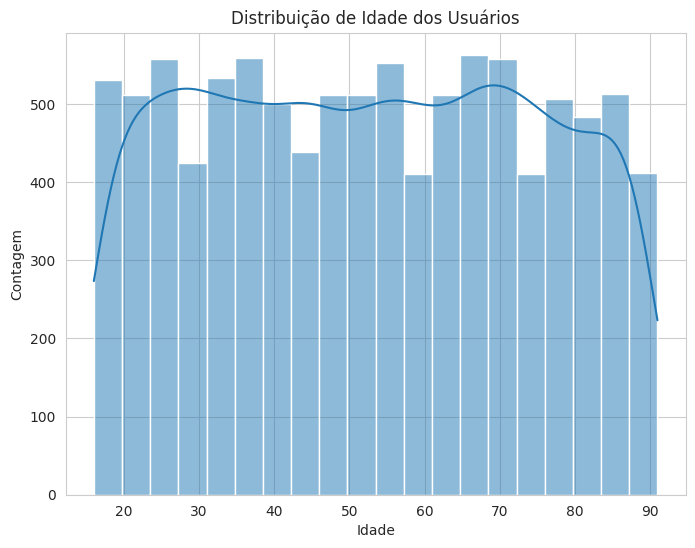


--- Análise Exploratória da Base de Transações ---

Top 10 Categorias de Estabelecimento por Transação:
categoria_estabelecimento
Restaurantes & Gastronomia                  17849
Fast Food & Lanchonetes                     13338
Farmácias                                   12957
Saúde & Bem-estar                           12580
Moda & Varejo                                9442
Academias                                    9325
Supermercados & Mercados                     9252
Cultura & Lazer                              6232
Lojas de Departamento & Eletrodomésticos     5937
Cafeterias                                   3088
Name: count, dtype: int64


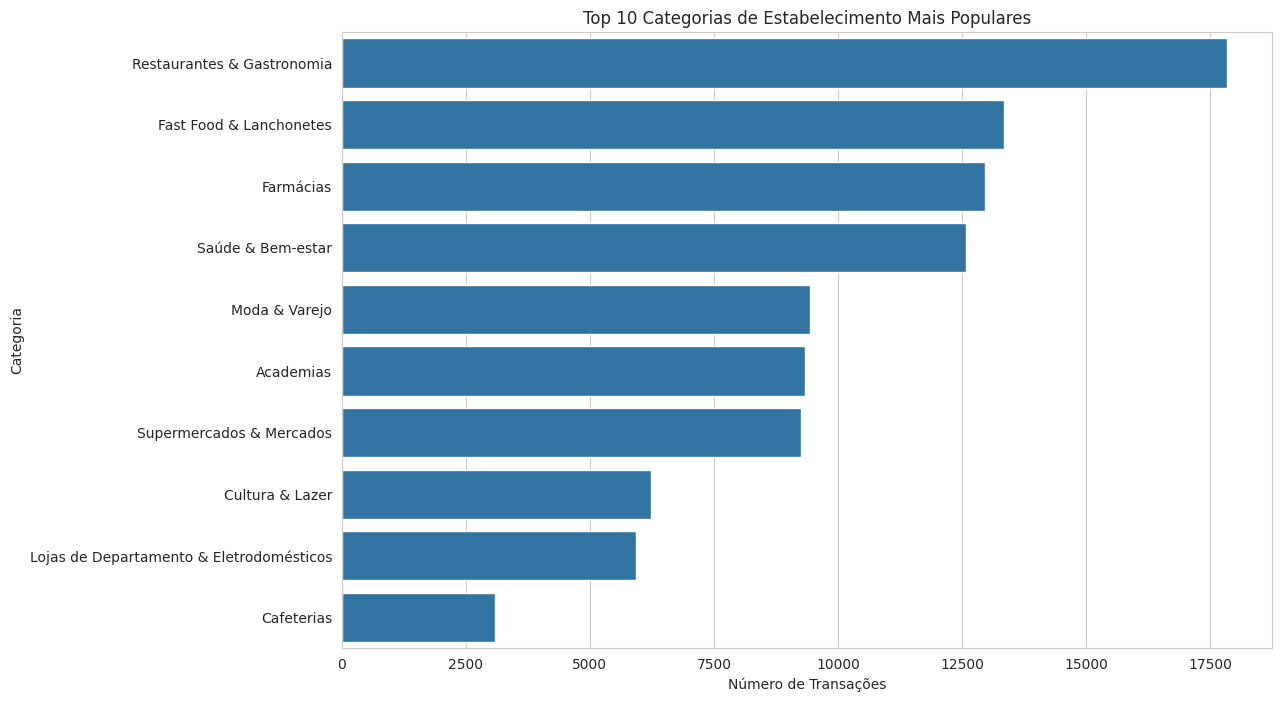


Estatísticas do Repasse para a PicMoney:
count   100000.00
mean        70.47
std         90.82
min          1.07
25%         16.18
50%         32.81
75%         80.16
max        497.32
Name: repasse_picmoney, dtype: float64


In [14]:
# Carregando os dataframes limpos
df_players_cleaned = pd.read_csv('players_cleaned.csv')
df_transacoes_cleaned = pd.read_csv('transacoes_cleaned.csv')

print("--- Análise Exploratória da Base de Players ---")
print("\nDistribuição por sexo:")
print(df_players_cleaned['sexo'].value_counts())

plt.figure(figsize=(8, 6))
sns.histplot(df_players_cleaned['idade'], bins=20, kde=True)
plt.title('Distribuição de Idade dos Usuários')
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.show()


print("\n--- Análise Exploratória da Base de Transações ---")
print("\nTop 10 Categorias de Estabelecimento por Transação:")
print(df_transacoes_cleaned['categoria_estabelecimento'].value_counts().head(10))


# Gráfico de barras das top 10 categorias
plt.figure(figsize=(12, 8))
sns.countplot(y='categoria_estabelecimento', data=df_transacoes_cleaned, order = df_transacoes_cleaned['categoria_estabelecimento'].value_counts().index[:10])
plt.title('Top 10 Categorias de Estabelecimento Mais Populares')
plt.xlabel('Número de Transações')
plt.ylabel('Categoria')
plt.show()

print("\nEstatísticas do Repasse para a PicMoney:")
print(df_transacoes_cleaned['repasse_picmoney'].describe())

Arquivos limpos carregados com sucesso.


/tmp/ipython-input-4175211763.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_bairros.values, y=top_10_bairros.index, palette='viridis', orient='h')


Gráfico de distribuição de usuários por bairro salvo como 'analise_bairros_usuarios.png'


/tmp/ipython-input-4175211763.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=faixa_etaria_counts.index, y=faixa_etaria_counts.values, palette='magma')


Gráfico de distribuição de usuários por faixa etária salvo como 'analise_faixa_etaria.png'


/tmp/ipython-input-4175211763.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=receita_por_categoria.values, y=receita_por_categoria.index, palette='plasma', orient='h')


Gráfico de receita por categoria salvo como 'analise_receita_categoria.png'


/tmp/ipython-input-4175211763.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=transacoes_por_dia.index, y=transacoes_por_dia.values, palette='cividis')


Gráfico de transações por dia da semana salvo como 'analise_transacoes_dia_semana.png'


/tmp/ipython-input-4175211763.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gasto_por_faixa_etaria = df_merged.groupby('faixa_etaria')['valor_cupom'].sum().sort_index()
/tmp/ipython-input-4175211763.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gasto_por_faixa_etaria.index, y=gasto_por_faixa_etaria.values, palette='rocket')


Gráfico de gasto por faixa etária salvo como 'analise_gasto_faixa_etaria.png'
Gráfico de preferência de categoria por gênero salvo como 'analise_preferencia_genero.png'


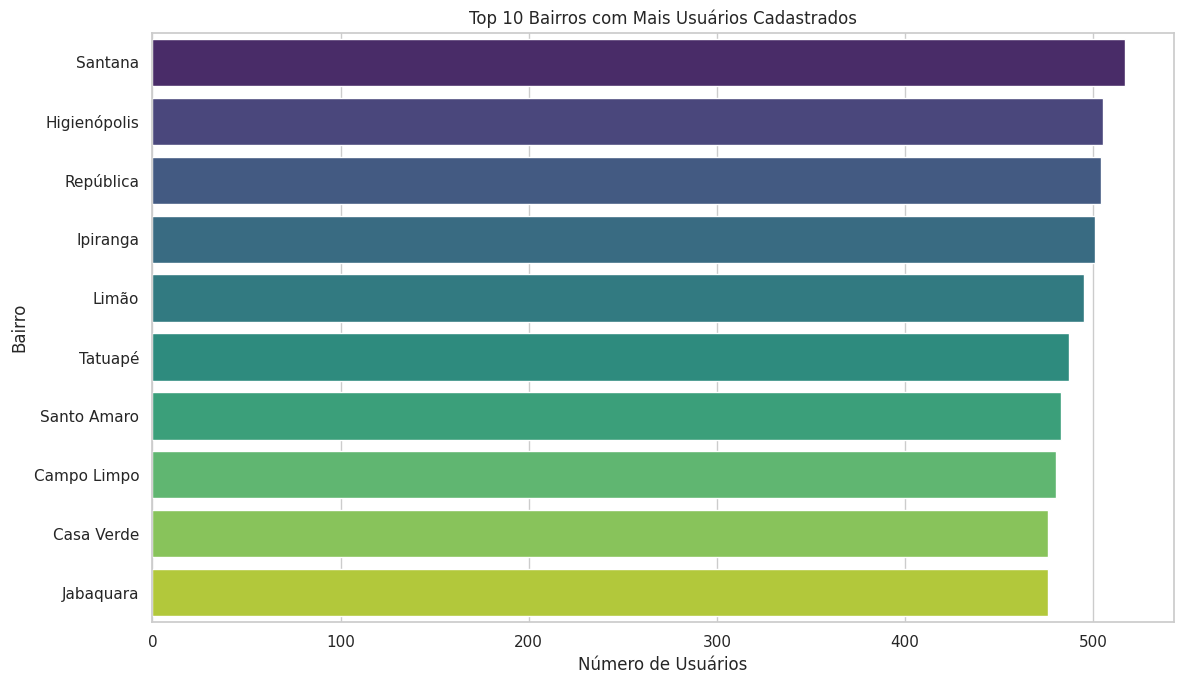

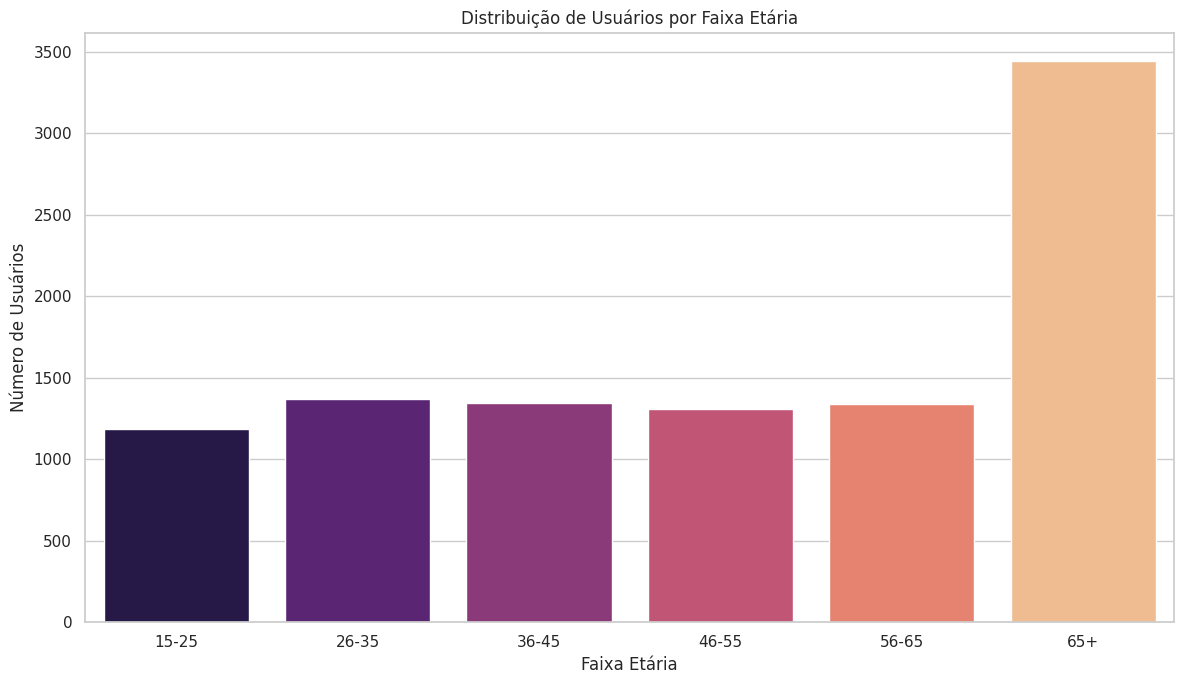

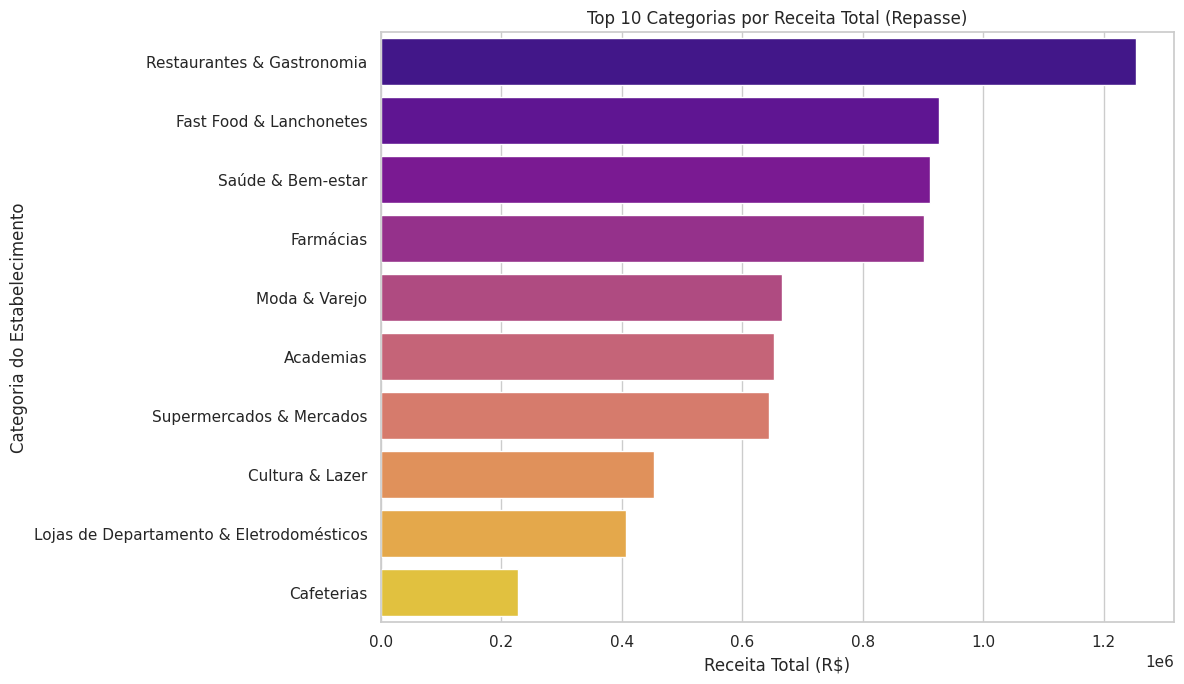

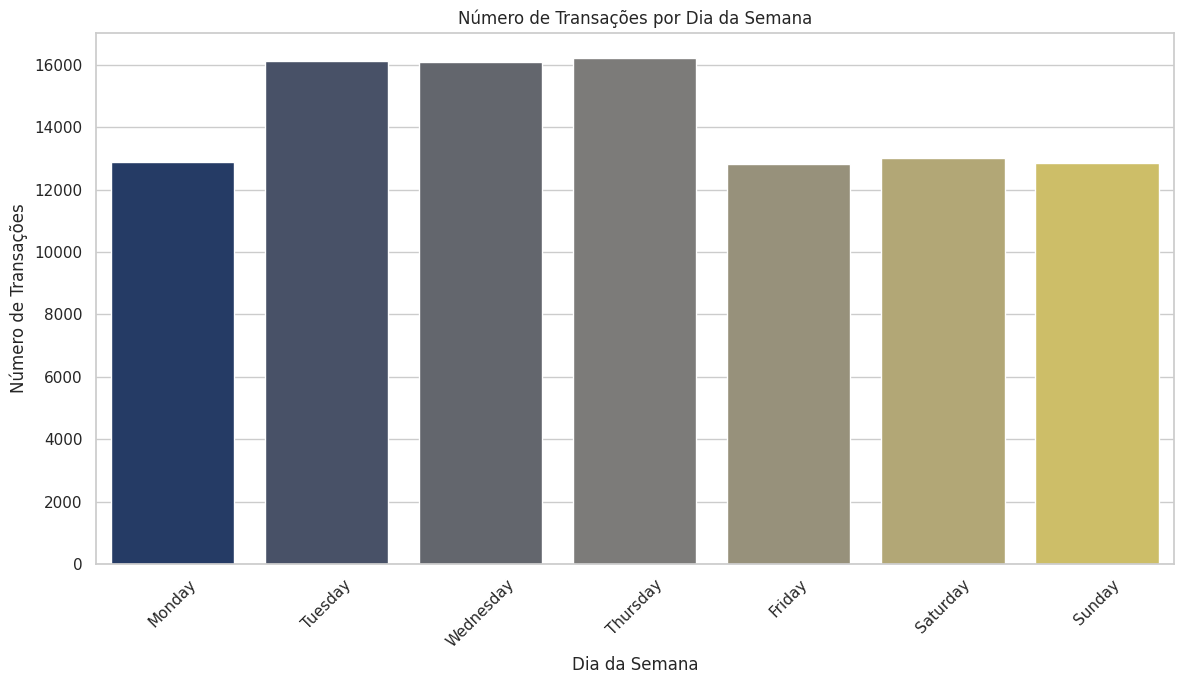

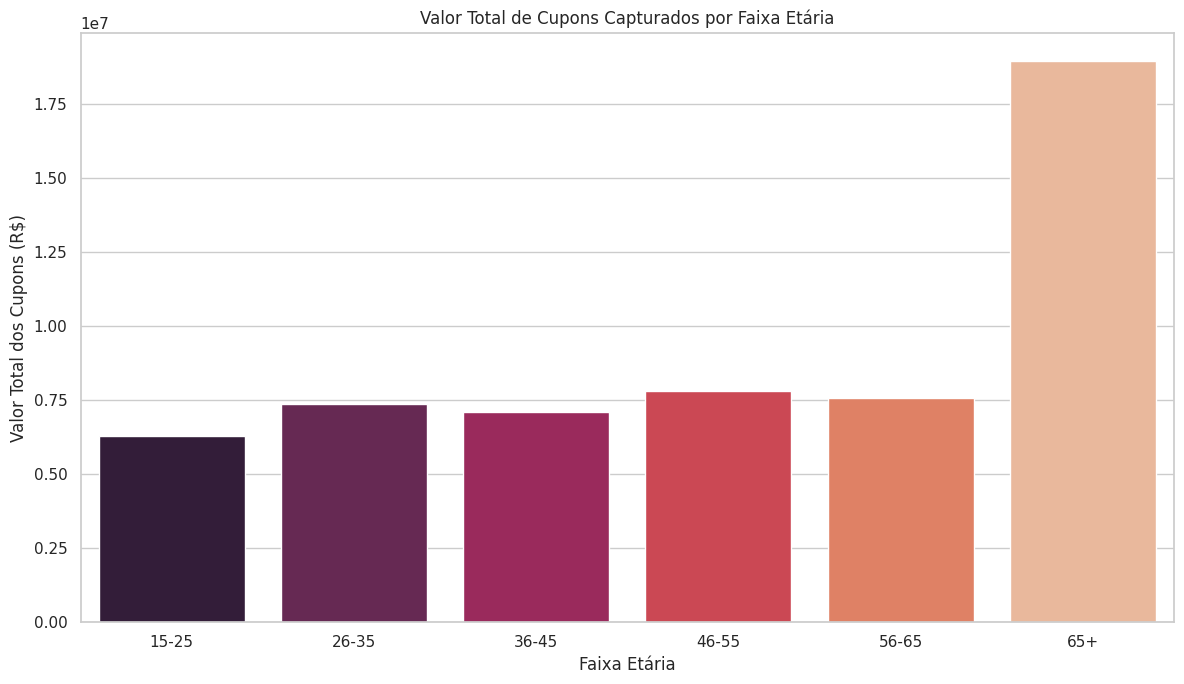

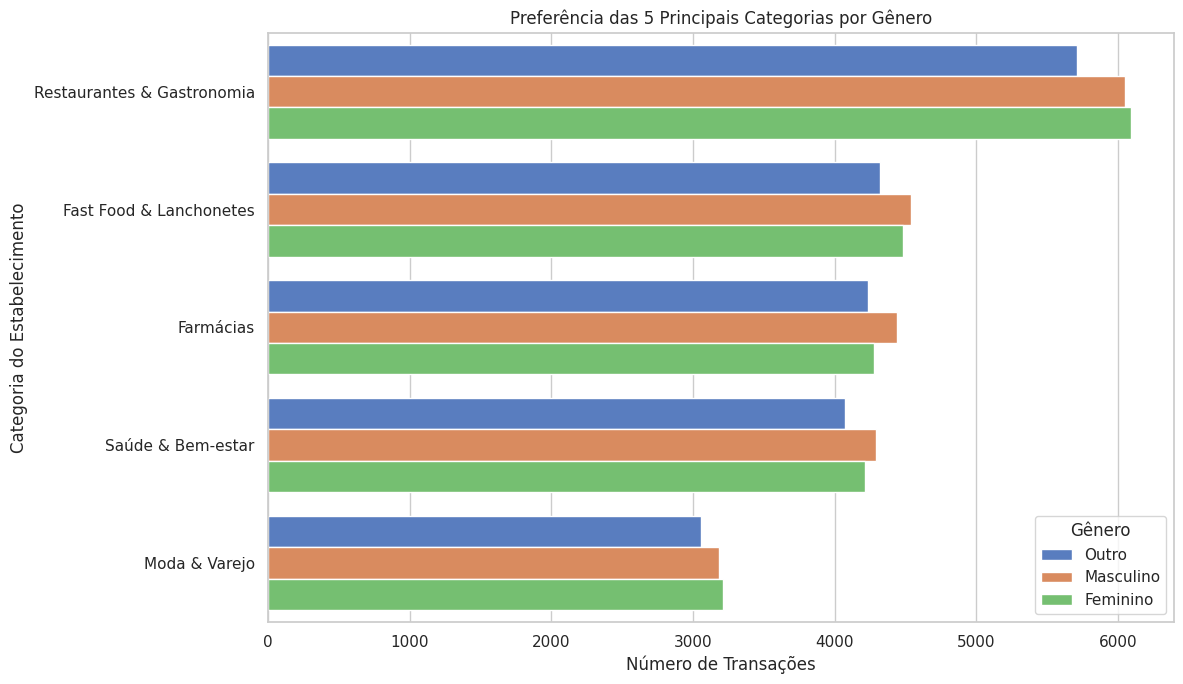

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de visualização
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['font.size'] = 12

# Carregar os dataframes limpos
try:
    df_players = pd.read_csv('players_cleaned.csv')
    df_transacoes = pd.read_csv('transacoes_cleaned.csv')
    df_pedestres = pd.read_csv('pedestres_cleaned.csv')
    df_lojas = pd.read_csv('lojas_cleaned.csv')
    print("Arquivos limpos carregados com sucesso.")
except FileNotFoundError:
    print("Erro: Arquivos limpos não encontrados. Execute o script de limpeza primeiro.")
    exit()

# --- Análise 1: Aprofundamento na Base de Usuários (Players) ---

# 1.1: Distribuição de usuários por bairro em São Paulo
plt.figure()
top_10_bairros = df_players['bairro_residencial'].value_counts().nlargest(10)
sns.barplot(x=top_10_bairros.values, y=top_10_bairros.index, palette='viridis', orient='h')
plt.title('Top 10 Bairros com Mais Usuários Cadastrados')
plt.xlabel('Número de Usuários')
plt.ylabel('Bairro')
plt.tight_layout()
plt.savefig('analise_bairros_usuarios.png')
print("Gráfico de distribuição de usuários por bairro salvo como 'analise_bairros_usuarios.png'")


# 1.2: Distribuição de usuários por faixa etária
bins = [15, 25, 35, 45, 55, 65, 100]
labels = ['15-25', '26-35', '36-45', '46-55', '56-65', '65+']
df_players['faixa_etaria'] = pd.cut(df_players['idade'], bins=bins, labels=labels, right=False)

plt.figure()
faixa_etaria_counts = df_players['faixa_etaria'].value_counts().sort_index()
sns.barplot(x=faixa_etaria_counts.index, y=faixa_etaria_counts.values, palette='magma')
plt.title('Distribuição de Usuários por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Número de Usuários')
plt.tight_layout()
plt.savefig('analise_faixa_etaria.png')
print("Gráfico de distribuição de usuários por faixa etária salvo como 'analise_faixa_etaria.png'")


# --- Análise 2: Aprofundamento na Base de Transações ---

# 2.1: Receita total (Repasse) por Categoria de Estabelecimento
df_transacoes['data'] = pd.to_datetime(df_transacoes['data'])
receita_por_categoria = df_transacoes.groupby('categoria_estabelecimento')['repasse_picmoney'].sum().nlargest(10).sort_values(ascending=False)

plt.figure()
sns.barplot(x=receita_por_categoria.values, y=receita_por_categoria.index, palette='plasma', orient='h')
plt.title('Top 10 Categorias por Receita Total (Repasse)')
plt.xlabel('Receita Total (R$)')
plt.ylabel('Categoria do Estabelecimento')
plt.tight_layout()
plt.savefig('analise_receita_categoria.png')
print("Gráfico de receita por categoria salvo como 'analise_receita_categoria.png'")


# 2.2: Análise de transações por dia da semana
df_transacoes['dia_da_semana'] = df_transacoes['data'].dt.day_name()
dias_ordem = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
transacoes_por_dia = df_transacoes['dia_da_semana'].value_counts().reindex(dias_ordem)

plt.figure()
sns.barplot(x=transacoes_por_dia.index, y=transacoes_por_dia.values, palette='cividis')
plt.title('Número de Transações por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Número de Transações')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('analise_transacoes_dia_semana.png')
print("Gráfico de transações por dia da semana salvo como 'analise_transacoes_dia_semana.png'")


# --- Análise 3: Análise Combinada (Players + Transações) ---

# 3.1: Juntando as bases para uma análise de perfil de consumo
df_merged = pd.merge(df_transacoes, df_players, on='celular', how='inner')

# 3.2: Gasto (valor_cupom) por faixa etária
gasto_por_faixa_etaria = df_merged.groupby('faixa_etaria')['valor_cupom'].sum().sort_index()

plt.figure()
sns.barplot(x=gasto_por_faixa_etaria.index, y=gasto_por_faixa_etaria.values, palette='rocket')
plt.title('Valor Total de Cupons Capturados por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Valor Total dos Cupons (R$)')
plt.tight_layout()
plt.savefig('analise_gasto_faixa_etaria.png')
print("Gráfico de gasto por faixa etária salvo como 'analise_gasto_faixa_etaria.png'")

# 3.3: Preferência de categoria por sexo
plt.figure()
top_categorias = df_merged['categoria_estabelecimento'].value_counts().nlargest(5).index
df_top_categorias = df_merged[df_merged['categoria_estabelecimento'].isin(top_categorias)]

sns.countplot(y='categoria_estabelecimento', hue='sexo', data=df_top_categorias, order=top_categorias, palette='muted')
plt.title('Preferência das 5 Principais Categorias por Gênero')
plt.xlabel('Número de Transações')
plt.ylabel('Categoria do Estabelecimento')
plt.legend(title='Gênero')
plt.tight_layout()
plt.savefig('analise_preferencia_genero.png')
print("Gráfico de preferência de categoria por gênero salvo como 'analise_preferencia_genero.png'")

plt.show()

Arquivos limpos carregados com sucesso para análise.
-> Gráfico 'analise_evolucao_receita_usuarios.png' guardado com sucesso.


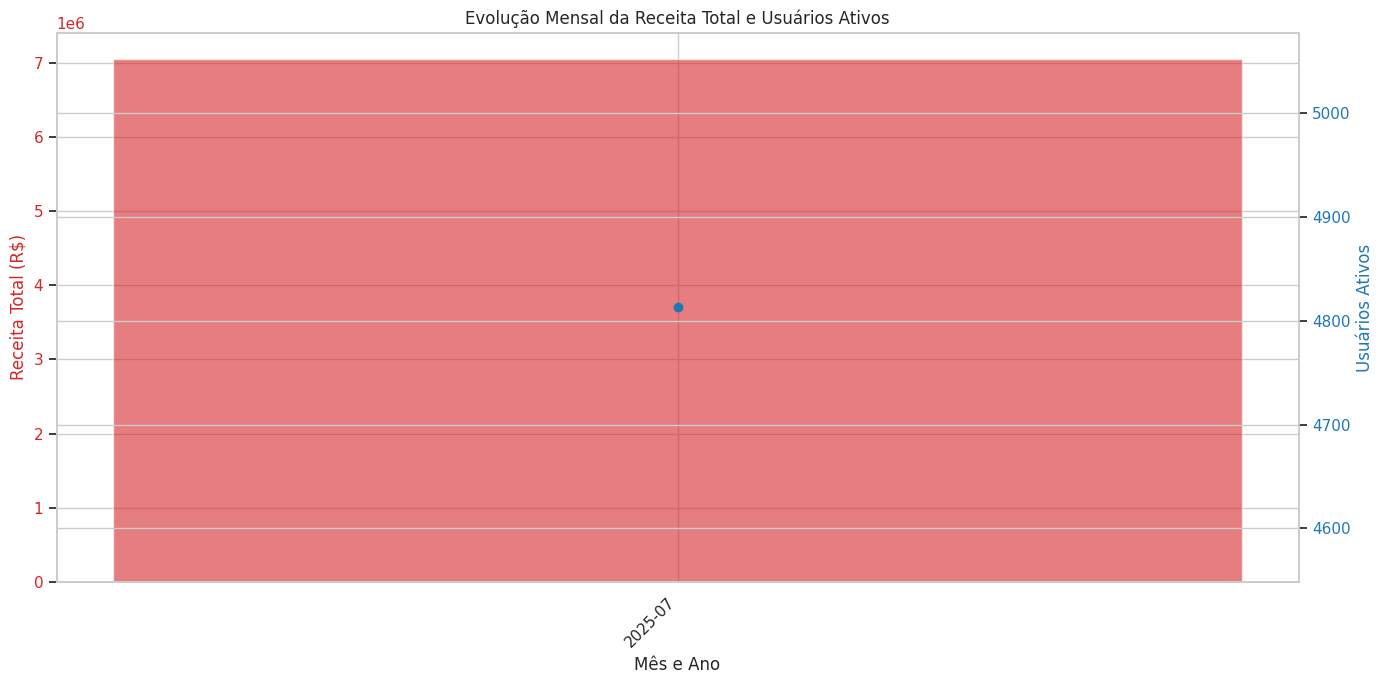

/tmp/ipython-input-2563585426.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=receita_por_categoria.values, y=receita_por_categoria.index, palette='plasma', orient='h')


-> Gráfico 'analise_receita_categoria_replicada.png' guardado com sucesso.


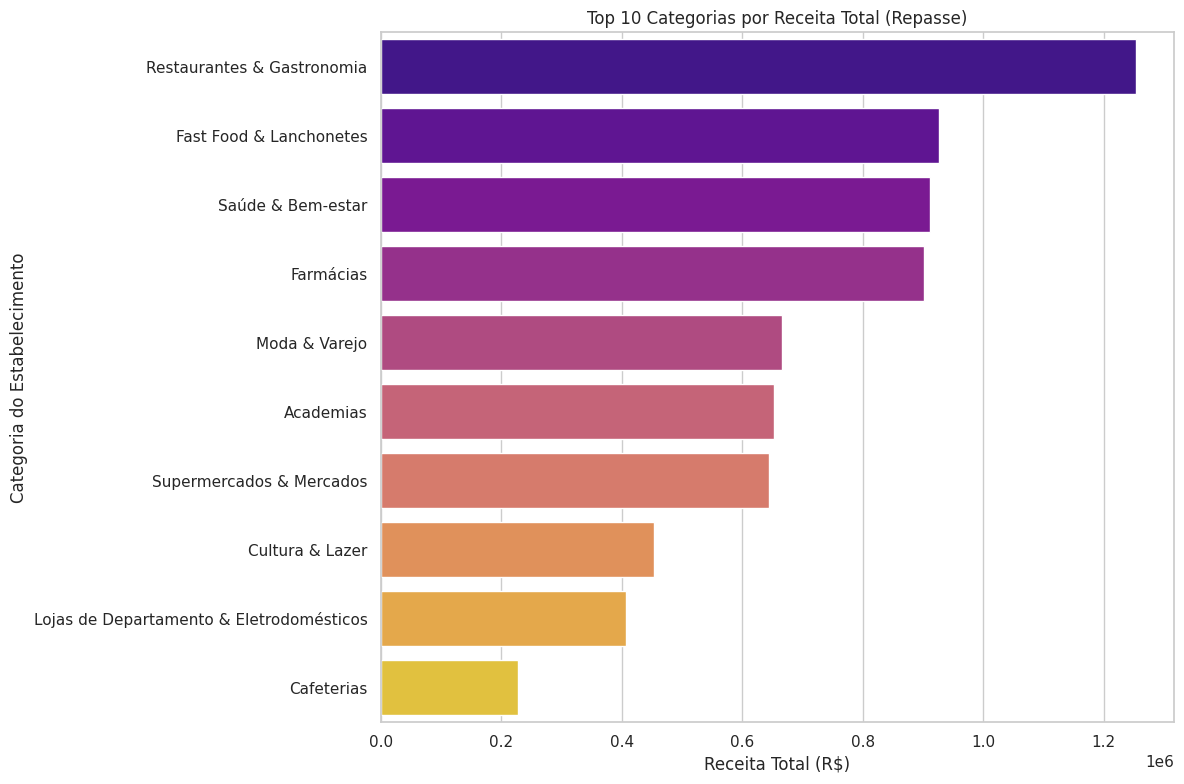

-> Gráfico 'analise_distribuicao_valor_cupom.png' guardado com sucesso.


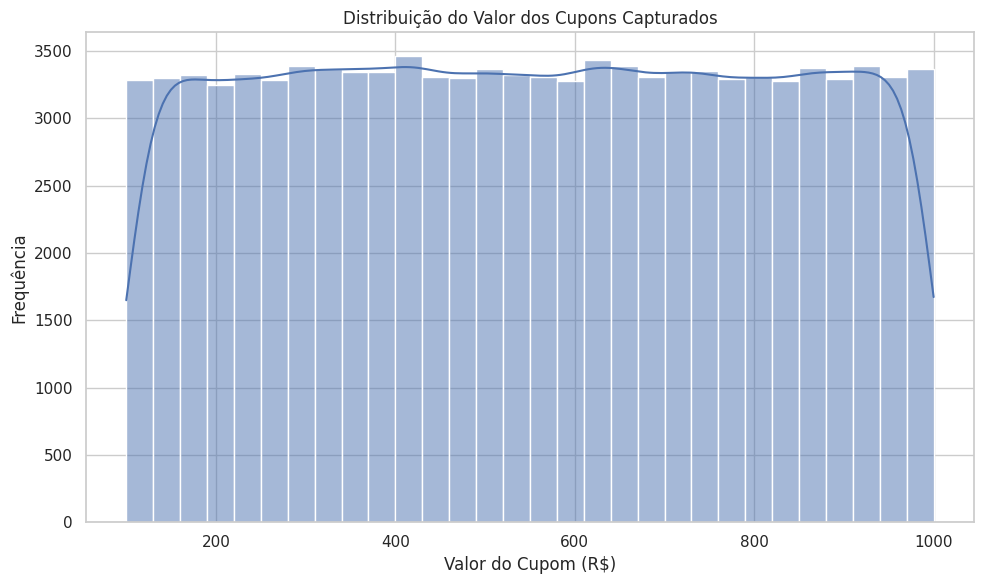

/tmp/ipython-input-2563585426.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=receita_por_bairro.values, y=receita_por_bairro.index, palette='viridis', orient='h')


-> Gráfico 'analise_performance_bairro.png' guardado com sucesso.


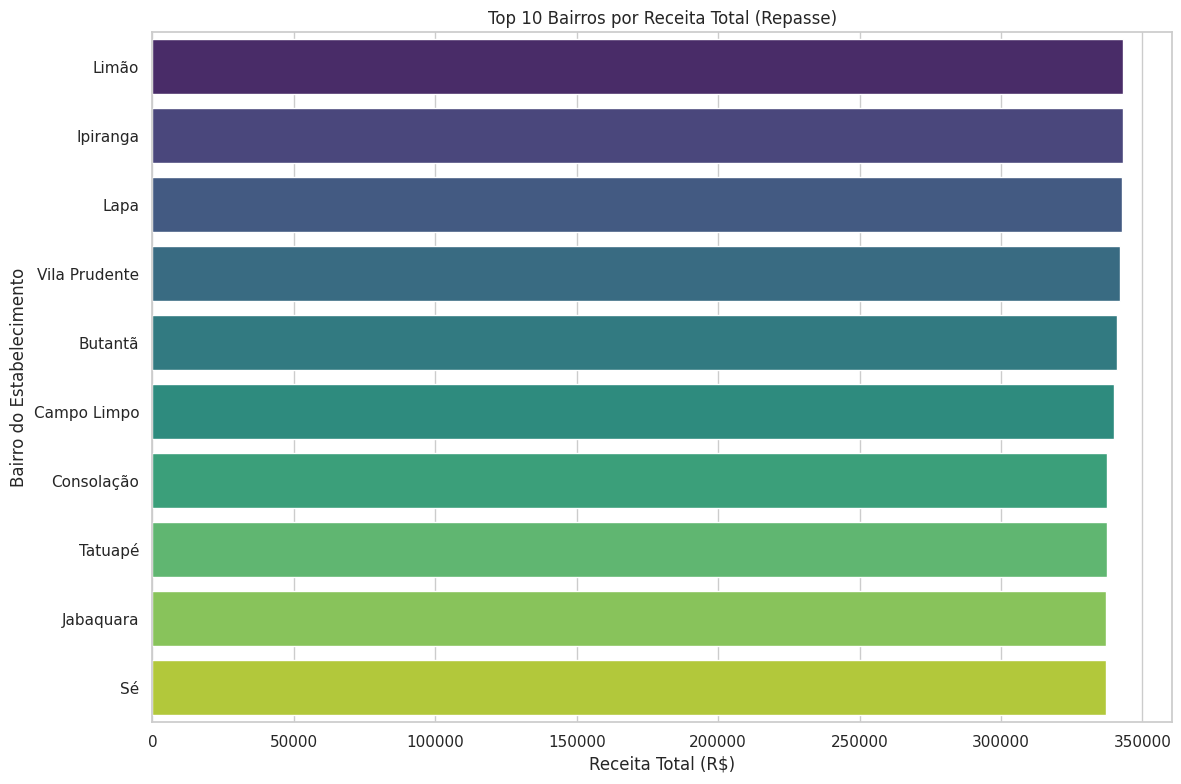


--- ANÁLISE DE KPIS CONCLUÍDA ---


In [16]:
try:
    df_players = pd.read_csv('players_cleaned.csv')
    df_transacoes = pd.read_csv('transacoes_cleaned.csv')
    df_pedestres = pd.read_csv('pedestres_cleaned.csv')
    df_lojas = pd.read_csv('lojas_cleaned.csv')
    print("Arquivos limpos carregados com sucesso para análise.")
except FileNotFoundError:
    print("Erro: Arquivos limpos não encontrados. A Etapa 1 pode ter falhado.")
    exit()

# 4.1: Evolução da Receita x Usuários Ativos (Mensal)
df_transacoes['data'] = pd.to_datetime(df_transacoes['data'])
df_transacoes['mes_ano'] = df_transacoes['data'].dt.to_period('M')
receita_mensal = df_transacoes.groupby('mes_ano')['repasse_picmoney'].sum().reset_index()
receita_mensal['mes_ano'] = receita_mensal['mes_ano'].astype(str)
usuarios_ativos_mensal = df_transacoes.groupby('mes_ano')['celular'].nunique().reset_index()
usuarios_ativos_mensal['mes_ano'] = usuarios_ativos_mensal['mes_ano'].astype(str)
usuarios_ativos_mensal.rename(columns={'celular': 'usuarios_ativos'}, inplace=True)
df_evolucao = pd.merge(receita_mensal, usuarios_ativos_mensal, on='mes_ano')

fig, ax1 = plt.subplots(figsize=(14, 7))
color = 'tab:red'
ax1.set_xlabel('Mês e Ano')
ax1.set_ylabel('Receita Total (R$)', color=color)
ax1.bar(df_evolucao['mes_ano'], df_evolucao['repasse_picmoney'], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Usuários Ativos', color=color)
ax2.plot(df_evolucao['mes_ano'], df_evolucao['usuarios_ativos'], color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Evolução Mensal da Receita Total e Usuários Ativos')
fig.tight_layout()
plt.savefig('analise_evolucao_receita_usuarios.png')
print("-> Gráfico 'analise_evolucao_receita_usuarios.png' guardado com sucesso.")
plt.show()

# 4.2: Receita por Categoria
receita_por_categoria = df_transacoes.groupby('categoria_estabelecimento')['repasse_picmoney'].sum().nlargest(10).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=receita_por_categoria.values, y=receita_por_categoria.index, palette='plasma', orient='h')
plt.title('Top 10 Categorias por Receita Total (Repasse)')
plt.xlabel('Receita Total (R$)')
plt.ylabel('Categoria do Estabelecimento')
plt.tight_layout()
plt.savefig('analise_receita_categoria_replicada.png')
print("-> Gráfico 'analise_receita_categoria_replicada.png' guardado com sucesso.")
plt.show()

# 4.3: Distribuição de Cupons por Valor
plt.figure(figsize=(10, 6))
sns.histplot(df_transacoes['valor_cupom'], bins=30, kde=True)
plt.title('Distribuição do Valor dos Cupons Capturados')
plt.xlabel('Valor do Cupom (R$)')
plt.ylabel('Frequência')
plt.tight_layout()
plt.savefig('analise_distribuicao_valor_cupom.png')
print("-> Gráfico 'analise_distribuicao_valor_cupom.png' guardado com sucesso.")
plt.show()

# 4.4: Performance por Região
receita_por_bairro = df_transacoes.groupby('bairro_estabelecimento')['repasse_picmoney'].sum().nlargest(10).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=receita_por_bairro.values, y=receita_por_bairro.index, palette='viridis', orient='h')
plt.title('Top 10 Bairros por Receita Total (Repasse)')
plt.xlabel('Receita Total (R$)')
plt.ylabel('Bairro do Estabelecimento')
plt.tight_layout()
plt.savefig('analise_performance_bairro.png')
print("-> Gráfico 'analise_performance_bairro.png' guardado com sucesso.")
plt.show()

print("\n--- ANÁLISE DE KPIS CONCLUÍDA ---")
